# EMAMTM0048-Coursework Part3 : Data Analytics

## 1.Abstract

The data I extracted in this assignment is the recent match data of a game called DOTA 2. By analyzing the winning situation and hero usage data of the match data, I understand the winning rate of the two camps after the update of the new version, as well as the use situation and winning rate of each hero. In the follow-up work, the deep learning model can also be used to model and analyze the match data of DOTA 2, so as to provide guidance in hero selection and installation, and help players improve the ladder level.

## 2.Data source

OpenDota website (https://www.opendota.com/) provides a complete set of API interface can obtain dota2 data such as data has to choose between the two sides in the hero, the game time, game players average ladder scores. Through browsing the website, I found that the data is relatively complete and meets the needs of analysis.

Dota2 game data provided by OpenDota API to obtain, through reading the API documentation (https://docs.opendota.com/#), found a few interesting/useful interface:
    1.Request a single game:
    https://api.opendota.com/api/matches/{match_id}
    This URL can be called based on the match ID to get the details of a single match, including game start time, game duration, game mode, lobby mode, number of remaining barracks in Skyglow/Nightmare, player information, and even in-game chat messages.
    2.Find 10 matches at random:
    https://api.opendota.com/api/findMatches
    The URL will randomly return the basic data of 10 recent matches, including the start time of the game, the hero ID of both sides, and whether Tianhui has won or not.
    3.Find the hero ID corresponding name:
    https://api.opendota.com/api/heroes
    The interface URL returns the basic information about the hero, including the hero's properties, melee/range, hero's name, how many legs the hero has, and so on. We use only one piece of information, the hero name.
    4.Open match search
    https://api.opendota.com/api/publicMatches? less_than_match_id={match_id}
    The URL of this interface can query the online match data we need. The input parameter less_than_match_id refers to the match_id of a certain game. This interface will return 100 match data less than this match_id, including the game time, duration, game mode, hall mode, heroes of both sides, whether Tianghui wins or not, etc. The data required for this modeling is obtained through this interface.


## 3.Extracted game match data

To analyze the win rate through the selection of heroes from both sides, we need to obtain the following data: [list of heroes from the side of Radiant], [list of heroes from the side of dire], and [which side wins].
In addition, in order to ensure the quality of the matches climbed, the following restrictions were set: average match level > 4000, game time BBB> minutes (excluding second withdrawal), ladder match (avoiding random hero selection in normal matches).

In [1]:
import json
import requests
import time

base_url = 'https://api.opendota.com/api/publicMatches?less_than_match_id='
session = requests.Session()
#camouflage
session.headers = {     'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/56.0.2924.87 Safari/537.36'}
def crawl(input_url):
    time.sleep(1)  # Pause for one second to prevent requests from moving too fast and causing the site to be blocked.
    crawl_tag = 0
    while crawl_tag == 0:
        try:
            session.get("http://www.opendota.com/")  # Got the cookie of the website
            content = session.get(input_url)
            crawl_tag = 1
        except:
            print(u"Poor internet connection. We'll have another try.")
    json_content = json.loads(content.text)
    return json_content

Here I use the request package to create a public session, which simulates the browser making a request to the server. Next, edit the crawl() function with the input_url parameter representing the API link address provided by OpenDota. Since there is no top up member, only one request can be sent to the server every second, so use the sleep function to pause the program for a second, to prevent too fast call to cause exceptions. Since the data returned by the API is in JSON format, we use the json.loads() function to parse it.
Next, complete the filtering and recording of data:

In [2]:
max_match_id = 5771061941    # Set a maximum value as match_ID to find the most recent match (that is, the match with the largest match_ID).
target_match_num = 150 #Sets the amount of data to get
lowest_mmr = 4000  # Match the positioning line and screen the ladder match above the score
match_list = []
recurrent_times = 0
write_tag = 0
with open('../SDPA_Part3/matches_list_ranking.csv','w',encoding='utf-8') as fout:
    fout.write('Match_ID,Time,RHero1,RHero2,RHero3,RHero4,RHero5,DHero1,DHero2,DHero3,DHero4,DHero5,mmr,Rwin\n')
    while (len(match_list) < target_match_num):
        json_content = crawl(base_url + str(max_match_id))
        for i in range(len(json_content)):
            match_id = json_content[i]['match_id']
            radiant_win = json_content[i]['radiant_win']
            start_time = json_content[i]['start_time']
            avg_mmr = json_content[i]['avg_mmr']
            if avg_mmr == None:
                avg_mmr = 0
            lobby_type = json_content[i]['lobby_type']
            game_mode = json_content[i]['game_mode']
            radiant_team = json_content[i]['radiant_team']
            dire_team = json_content[i]['dire_team']
            duration = json_content[i]['duration']  # Duration of Competition
            if int(avg_mmr) < lowest_mmr:  # Match level is too low. Ignore
                continue
            if int(duration) < 900:  # If the match time is too short (less than 15min), it will be deemed that someone dropped the line.
                continue
            if int(lobby_type) != 7 or (int(game_mode) != 3 and int(game_mode) != 22): # Where lobby_type=7 is the ladder match, Game_mode =3 is the random conscription mode, game_mode=22 is the ladder all-hero selection mode
                continue
            x = time.localtime(int(start_time))
            game_time = time.strftime('%Y-%m-%d %H:%M:%S', x)
            one_game = [game_time, radiant_team, dire_team, avg_mmr, radiant_win, match_id]
            match_list.append(one_game)
        max_match_id = json_content[-1]['match_id']
        recurrent_times += 1
        #print(recurrent_times, len(match_list), max_match_id)
        if len(match_list) > target_match_num:
            match_list = match_list[:target_match_num]
        if write_tag < len(match_list):  # If it is less than the length of the new match list, the new match is written to the file
            for i in range(len(match_list))[write_tag:]:
                fout.write(str(match_list[i][5]) + ', ' + match_list[i][0] + ', ' + match_list[i][1] + ', ' + \
                match_list[i][2] + ', ' + str(match_list[i][3]) +  ', ' + str(match_list[i][4]) +'\n')
                write_tag = len(match_list)
print("Crawl successful")

1 17 5771060801
2 27 5771059616
3 34 5771058300
4 40 5771057014
5 44 5771055904
6 49 5771054502
7 56 5771053208
8 65 5771051903
9 69 5771050606
10 77 5771049301
11 83 5771048010
12 87 5771046914
13 95 5771045700
14 102 5771044419
15 111 5771043312
16 115 5771042016
17 121 5771040803
18 128 5771039514
19 129 5771038505
20 139 5771037317
21 150 5771036106
Crawl successful


In the code above, first define a MAX_MATCH_ID, which indicates the search for match data prior to the match, and two other variables, target_MATCH_NUM and lowest_MMR, represent the amount of match data to be recorded and the lowest match score, respectively.
The outer while loop determines whether the number of match data obtained reaches the target value or not. If not, the loop will continue. In each while loop, you retrieve the data returned by the server through the Crawl () function. An inner for loop parses and filters each column of JSON data (where lobby_type=7 is a ladder match, game_mode=3 is a random call, and game_mode=22 is a ladder hero selection). At the end of the for loop, update the value of MAX_MATCH_ID (corresponding to the last data of the current crawl, from which the next crawl will continue), and write the newly crawled data to the CSV data file. The work flow is shown in the square diagram below, where the blue box represents the condition judgment.

In addition, since the hero data obtained is the hero ID, I also need to get the hero name and ID corresponding table from the API

In [3]:
base_url='https://api.opendota.com/api/heroes'
write_tag = 0
session = requests.Session()
def crawl(input_url):
    time.sleep(
            1)  # Pause for one second to prevent requests from moving too fast and causing the site to be blocked.
    crawl_tag = 0
    while crawl_tag == 0:
        try:
            session.get("http://www.opendota.com/")  # Got the cookie of the website
            content = session.get(input_url)
            crawl_tag = 1
        except:
            print(u"Poor internet connection. We'll have another try.")
    json_content = json.loads(content.text)
    return json_content

hero_list=[]
#Write the data to a CSV file
with open('../SDPA_Part3/hero_list.csv','w',encoding='utf-8') as fout:
    fout.write('Hero_ID,Hero_name,primary_attr,attack_type\n')
    json_content = crawl(base_url)
    for i in range(len(json_content)):
        hero_id=json_content[i]["id"]
        hero_name=json_content[i]["localized_name"]
        primary_attr=json_content[i]["primary_attr"]
        attack_type=json_content[i]["attack_type"]

        one_game = [hero_id, hero_name, primary_attr, attack_type]
        hero_list.append(one_game)
    for i in range(len(hero_list)):
        fout.write(str(hero_list[i][0]) + ', ' + hero_list[i][1] + ', ' + hero_list[i][2] + ', ' + hero_list[i][3]  + '\n')
print("Crawl successful")

Crawl successful


The above code crawled 150 pieces of competition data, because I believe that only by analyzing more data can I get the conclusion I want, so I used the above code to adjust the data acquisition amount and crawled 10,000 pieces of competition data for analysis. The data results are as follows.

![jupyter](./data1.png)

## 4.Perform data preparation & cleaning

Because I have already done the filtering when crawling data, I will simply use Pandas to save the extracted data into the datafram

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import opendatasets as od
import os
%matplotlib inline

df_heros = pd.read_csv('../SDPA_Part3/hero_list.csv')
df_matches = pd.read_csv('../SDPA_Part3/matches_list_ranking2.csv')

print(df_heros)
print(df_matches)

     Hero_ID        Hero_name primary_attr attack_type
0          1        Anti-Mage          agi       Melee
1          2              Axe          str       Melee
2          3             Bane          int      Ranged
3          4      Bloodseeker          agi       Melee
4          5   Crystal Maiden          int      Ranged
..       ...              ...          ...         ...
115      121       Grimstroke          int      Ranged
116      123         Hoodwink          agi      Ranged
117      126      Void Spirit          int       Melee
118      128         Snapfire          str      Ranged
119      129             Mars          str       Melee

[120 rows x 4 columns]
        Match_ID                  Time  RHero1  RHero2  RHero3  RHero4  \
0     5771061809   2021-01-03 22:39:42      77      64      34      85   
1     5771061808   2021-01-03 22:39:42      95      74      14     123   
2     5771061612   2021-01-03 22:39:26      88       8      52      13   
3     5771061604   2

## 5.Perform exploratory analysis 
### 5.1 Winning odds on both sides
Since the maps of the two sides of the game are inconsistent and the players move in opposite directions, I want to know if the win rates of the two sides are balanced

Radiant Win: 5325 Dire Win: 4675


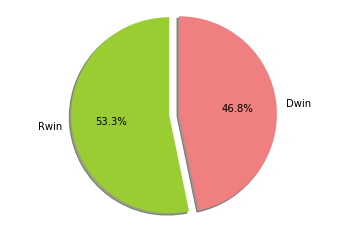

In [11]:
"""Show how both sides have won or lost"""
Num_Matches = len(df_matches)
Rwin = len(df_matches[df_matches['Rwin'] == ' True'])
Dwin = Num_Matches-Rwin
print("Radiant Win:",Rwin,"Dire Win:",Dwin)
labels = 'Rwin', 'Dwin'
sizes = [Rwin/100,Dwin/100]
colors = ['yellowgreen','lightcoral']
explode = (0, 0.1)
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=90)
# Set aspect ratio to be equal so that pie is drawn as a circle.
plt.axis('equal')
plt.show()

From the 10,000 race records of the climb, Radiant had 5,325 wins and Dire 4,675. This means that the current version of the map is not balanced as well. The win rate of Radiant is 6.5% higher than that of Dire.

### 5.2 Hero using times
I want to know how each hero is being used after the new version is updated

In [10]:
"""Statistics, see the use of heroes """
rhero1=df_matches['RHero1'].value_counts()
rhero2=df_matches['RHero2'].value_counts()
rhero3=df_matches['RHero3'].value_counts()
rhero4=df_matches['RHero4'].value_counts()
rhero5=df_matches['RHero5'].value_counts()
dhero1=df_matches['DHero1'].value_counts()
dhero2=df_matches['DHero2'].value_counts()
dhero3=df_matches['DHero3'].value_counts()
dhero4=df_matches['DHero4'].value_counts()
dhero5=df_matches['DHero5'].value_counts()
rhero=rhero1+rhero2+rhero3+rhero4+rhero5
dhero=dhero1+dhero2+dhero3+dhero4+dhero5
hero=rhero+dhero
df_heros_counts=pd.DataFrame(hero)
df_heros_counts.columns=['TIMES']
hero_name=df_heros.Hero_name.tolist()
hero_times=df_heros_counts.TIMES.tolist()
data={
        'hero_name':hero_name,
        'hero_times':hero_times
     }
df_usingtime=pd.DataFrame(data).sort_values(by=['hero_times'],ascending=False)
print(df_usingtime)

               hero_name  hero_times
7             Juggernaut        2219
13                 Pudge        2146
24                  Lion        2028
82             Ogre Magi        1998
72               Invoker        1916
..                   ...         ...
101          Elder Titan         185
74    Outworld Destroyer         170
78            Lone Druid         158
80                 Meepo         122
64                  Chen          67

[120 rows x 2 columns]


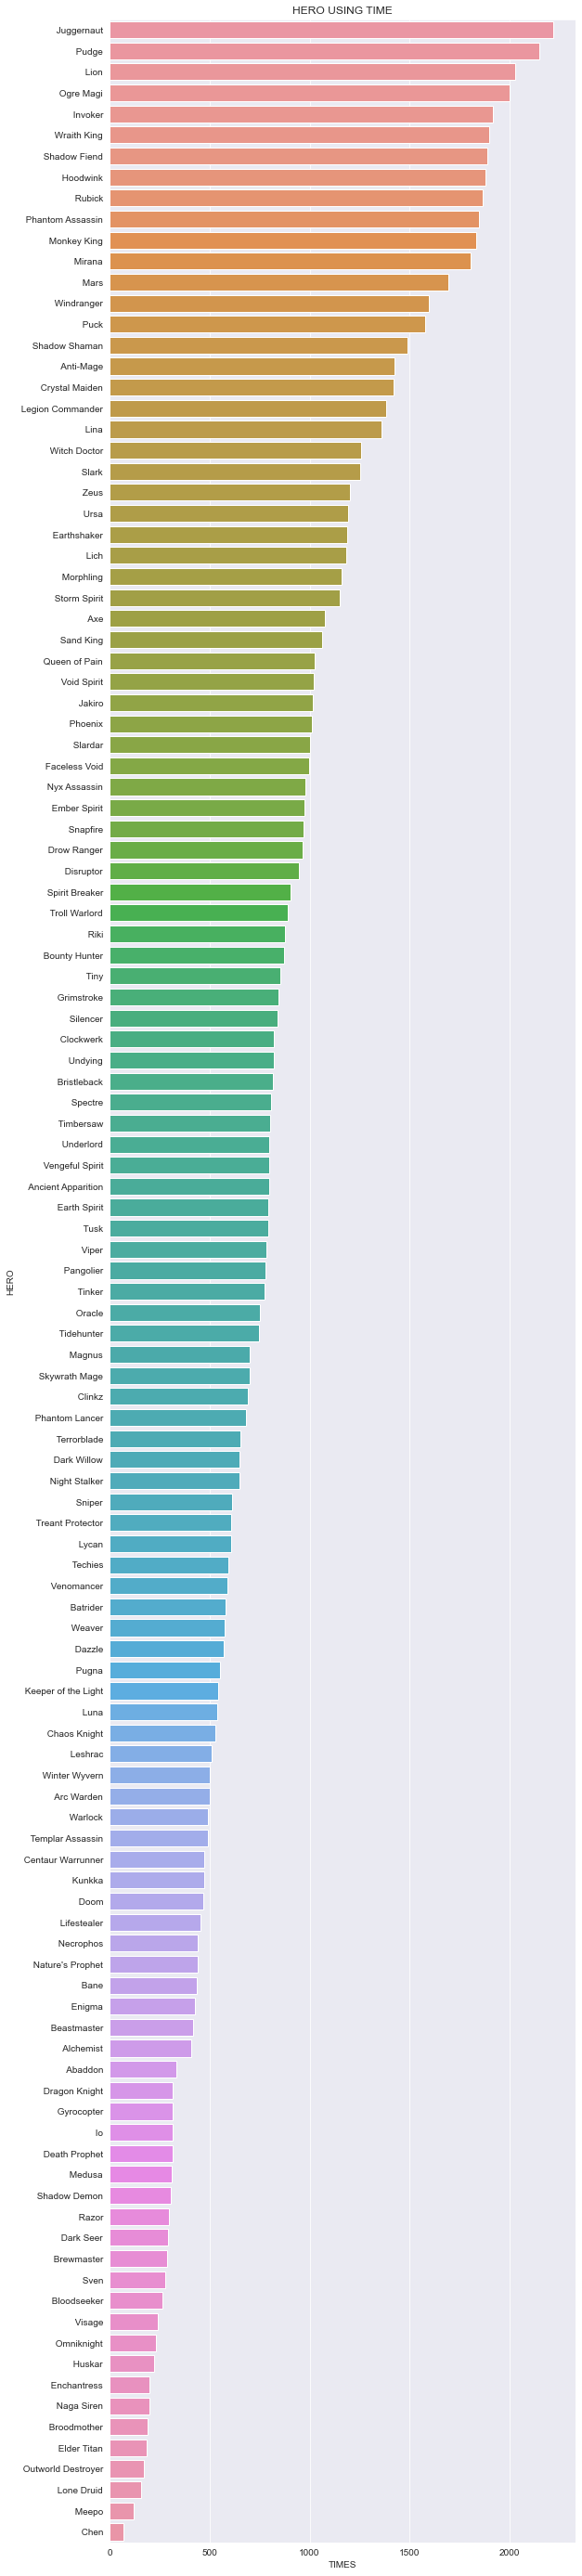

In [23]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

sns.set_style('darkgrid')
matplotlib.rcParams['font.size'] = 10
matplotlib.rcParams['figure.figsize'] = (9, 50)
matplotlib.rcParams['figure.facecolor'] = '#00000000'

sns.barplot(x=df_usingtime.hero_times, y=df_usingtime.hero_name)
plt.title("HERO USING TIME")
plt.ylabel("HERO");
plt.xlabel('TIMES');



To see may be due to the version of the update can also be a hero skill or strength, game hero by the largest number difference of use can be as high as 22.19%, equivalent to every five games there will be a candidate for the hero, compared to 0.61% of the lowest few people use this hero, this can also shows what kind of hero to strengthen


### 5.3 Hero's Win Rate 
With the hero usage data and the win and loss data, we can look at the hero win rate

In [29]:
df_rwin=df_matches[df_matches['Rwin'] == ' True']
df_dwin=df_matches[df_matches['Rwin'] == ' False']
rhero1=df_rwin['RHero1'].value_counts()
rhero2=df_rwin['RHero2'].value_counts()
rhero3=df_rwin['RHero3'].value_counts()
rhero4=df_rwin['RHero4'].value_counts()
rhero5=df_rwin['RHero5'].value_counts()
dhero1=df_dwin['DHero1'].value_counts()
dhero2=df_dwin['DHero2'].value_counts()
dhero3=df_dwin['DHero3'].value_counts()
dhero4=df_dwin['DHero4'].value_counts()
dhero5=df_dwin['DHero5'].value_counts()
rhero=rhero1+rhero2+rhero3+rhero4+rhero5
dhero=dhero1+dhero2+dhero3+dhero4+dhero5
hero=rhero+dhero
df_heros_wincounts=pd.DataFrame(hero)
df_heros_wincounts.columns=['TIMES']
hero_name=df_heros.Hero_name.tolist()
hero_wintimes=df_heros_wincounts.TIMES.tolist()
data={
        'hero_name':hero_name,
        'hero_wintimes':hero_wintimes
    }
df_herowintimes=pd.DataFrame(data).sort_values(by=['hero_wintimes'],ascending=False)
df_final=pd.merge(df_herowintimes, df_usingtime, on='hero_name')
df_final['winrate']=df_final['hero_wintimes']/df_final['hero_times']*100
df_herowinrate=df_final.sort_values(by=['winrate'],ascending=False)
print(df_herowinrate)

         hero_name  hero_wintimes  hero_times    winrate
34            Riki            499         876  56.963470
66           Lycan            341         607  56.177924
97           Razor            166         296  56.081081
75    Chaos Knight            296         530  55.849057
88          Enigma            239         428  55.841121
..             ...            ...         ...        ...
112     Omniknight             99         230  43.043478
63      Grimstroke            363         845  42.958580
107   Shadow Demon            130         304  42.763158
115    Elder Titan             79         185  42.702703
109           Sven            115         277  41.516245

[120 rows x 4 columns]


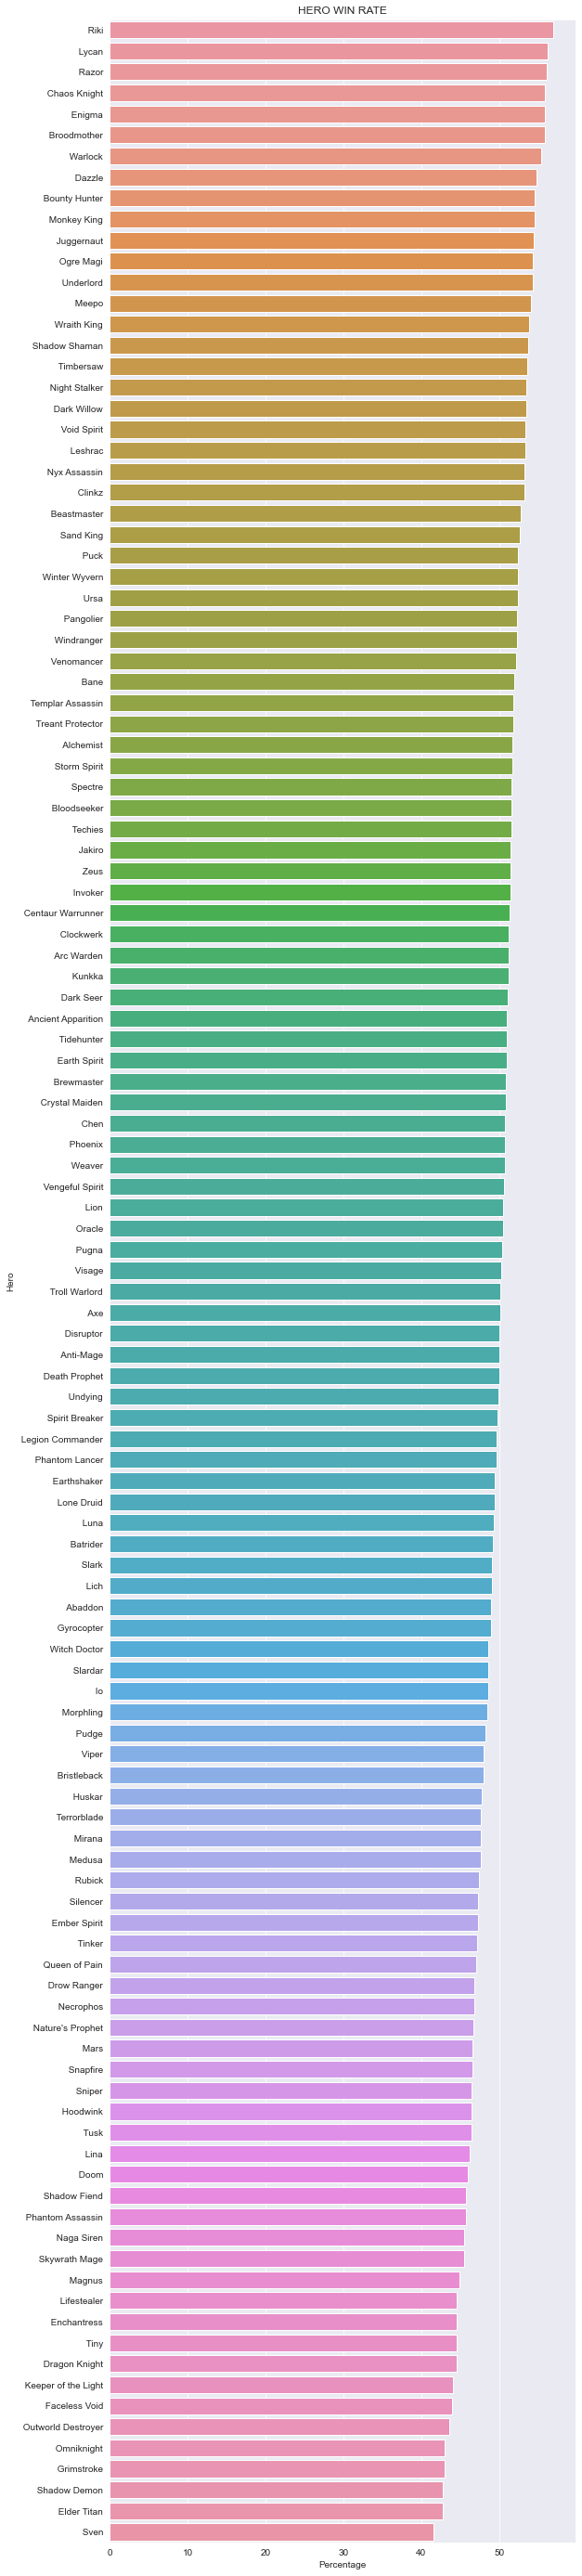

In [30]:
sns.barplot(x=df_herowinrate.winrate, y=df_herowinrate.hero_name)

plt.title("HERO WIN RATE")
plt.ylabel('Hero');
plt.xlabel('Percentage');


This shows that there may still be an imbalance in hero strength, with the highest win rate reaching 56.96% and the lowest only 41.51%



## 6.Summarize and write a conclusion 

In this assignment, I took 10000 game data including the match time, both sides hero selection, the average score on both sides, and statistical analysis of these data is simple exploratory, got the odds on both sides, use number hero, a hero winning percentage, etc., I can see by the map from the odds of asymmetry and operating in a different direction and appear some game imbalance - winning percentage was 6.5% higher than the dire, radiant, these problems should be game design should be avoided; Heat also can be seen from the hero using frequency analysis hero, also can reflect a few heroes or difficult skill intensity inconsistencies, these also can adjust the point, the hero of the break-even analysis can be seen that some hero has the highest winning percentage and the difference can reach 56.96% of the lowest is only 41.51%, also reflects some unbalanced design.

Existing problems: 
1.Data quantity is insufficient, 10000 pieces of data is still very small, and more data may need to be extracted in order to carry out the following analysis
2.Player level was not taken into account. Although I extracted the average ladder score of both players, I did not use it in this analysis, because the amount of data might be insufficient if we had to discuss it by case

Ideas for the future：
1.The deep learning model is used to model and analyze the matchup data of DOTA2, so as to make a win probability prediction by entering the face-ups of both sides
2.Through more data analysis, some of the hero's restraint relationships can be obtained, which leads to better choice hints